In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns

import matplotlib.pyplot as plt

from statannotations.Annotator import Annotator

from matplotlib import font_manager
import matplotlib

In [2]:

matplotlib.get_cachedir()

'/home/niklas/.cache/matplotlib'

In [66]:
plt.rcParams.update({
    "font.family": "Helvetica",
    "axes.labelsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "legend.title_fontsize": 6,
})
ytick_fontsize = 6

In [37]:
triton = {
    0: "Without Triton",
    2: "0.2 % Triton",
}
triton_order = [v for v in triton.values()]

def get_df(sheet_name):
    df = pd.read_excel(
    "/mnt/z/Dasha/2. FAST-AB biosensors/Microscope/Sensors in Salmonella and macrophages/Macr-Salmonella_TMP_Doxy_Triton_Niklas.xlsx",
    sheet_name=sheet_name,
    )

    for col in df.columns:
        if col == "Time, min":
            continue
        mi = df[col].min()
        ma = df[col].max()
        df[col] = (df[col] - mi) / (ma - mi)

    df = df.melt(id_vars="Time, min").dropna()

    df["split"] = df["variable"].str.split(" ")
    df["Antibiotic"] = df["split"].apply(lambda x: x[0])
    df["split2"] = df["split"].apply(lambda x: x[1]).str.split(".")
    df["Condition"] = df["split2"].apply(lambda x: triton[int(x[0])])
    df["Well"] = df["split2"].apply(lambda x: x[1])
    df["Position"] = df["split2"].apply(lambda x: x[2])
    
    return df

In [38]:
df = pd.concat([
    get_df(s) for s in ["Trimethoprim", "Doxycycline"]  # , "Tetracycline1", "Tetracycline2"]
], ignore_index=True)

In [39]:
df

,"Time, min",variable,value,split,Antibiotic,split2,Condition,Well,Position
0,0.000000,TMP 0.4.1,0.011594,"[TMP, 0.4.1]",TMP,"[0, 4, 1]",Without Triton,4,1
1,0.333333,TMP 0.4.1,0.012985,"[TMP, 0.4.1]",TMP,"[0, 4, 1]",Without Triton,4,1
2,0.666667,TMP 0.4.1,0.011063,"[TMP, 0.4.1]",TMP,"[0, 4, 1]",Without Triton,4,1
3,1.000000,TMP 0.4.1,0.006841,"[TMP, 0.4.1]",TMP,"[0, 4, 1]",Without Triton,4,1
4,1.333333,TMP 0.4.1,0.005578,"[TMP, 0.4.1]",TMP,"[0, 4, 1]",Without Triton,4,1
...,...,...,...,...,...,...,...,...,...
2716,56.000000,Doxy 2.6.3,0.737647,"[Doxy, 2.6.3]",Doxy,"[2, 6, 3]",0.2 % Triton,6,3
2717,57.000000,Doxy 2.6.3,0.654624,"[Doxy, 2.6.3]",Doxy,"[2, 6, 3]",0.2 % Triton,6,3
2718,58.000000,Doxy 2.6.3,0.637163,"[Doxy, 2.6.3]",Doxy,"[2, 6, 3]",0.2 % Triton,6,3
2719,59.000000,Doxy 2.6.3,0.814318,"[Doxy, 2.6.3]",Doxy,"[2, 6, 3]",0.2 % Triton,6,3


In [40]:
means = df.groupby(["Time, min", "Antibiotic", "Condition", "Well", "Position"])["value"].mean().reset_index()

In [57]:
inds = means["value"] > 0.5
time = "$T_{50}$ in min"
time = "T\u2085\u2080, min"
times = (means[inds].groupby(["Antibiotic", "Condition", "Well", "Position"])["Time, min"].min()-2).reset_index()
times = times.rename({"Time, min": time}, axis=1)

In [58]:
times

,Antibiotic,Condition,Well,Position,T₅₀ in min
0,Doxy,0.2 % Triton,4,1,4.000000
1,Doxy,0.2 % Triton,4,2,3.000000
2,Doxy,0.2 % Triton,4,3,2.000000
3,Doxy,0.2 % Triton,5,1,4.000000
4,Doxy,0.2 % Triton,5,2,5.000000
5,Doxy,0.2 % Triton,5,3,5.000000
6,Doxy,0.2 % Triton,6,1,4.000000
7,Doxy,0.2 % Triton,6,2,3.000000
8,Doxy,0.2 % Triton,6,3,4.000000
9,Doxy,Without Triton,1,1,16.000000


In [69]:
times.groupby(["Antibiotic", "Condition"])[time].mean()

Antibiotic  Condition     
Doxy        0.2 % Triton       3.777778
            Without Triton    13.666667
TMP         0.2 % Triton       0.888889
            Without Triton     1.185185
Name: T₅₀ in min, dtype: float64

In [70]:
times.groupby(["Antibiotic", "Condition"])[time].std()

Antibiotic  Condition     
Doxy        0.2 % Triton      0.971825
            Without Triton    1.870829
TMP         0.2 % Triton      0.500000
            Without Triton    0.175682
Name: T₅₀ in min, dtype: float64

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TMP_0.2 % Triton vs. TMP_Without Triton: Mann-Whitney-Wilcoxon test two-sided, P_val:1.930e-01 U_stat=2.600e+01
Doxy_0.2 % Triton vs. Doxy_Without Triton: Mann-Whitney-Wilcoxon test two-sided, P_val:3.582e-04 U_stat=0.000e+00


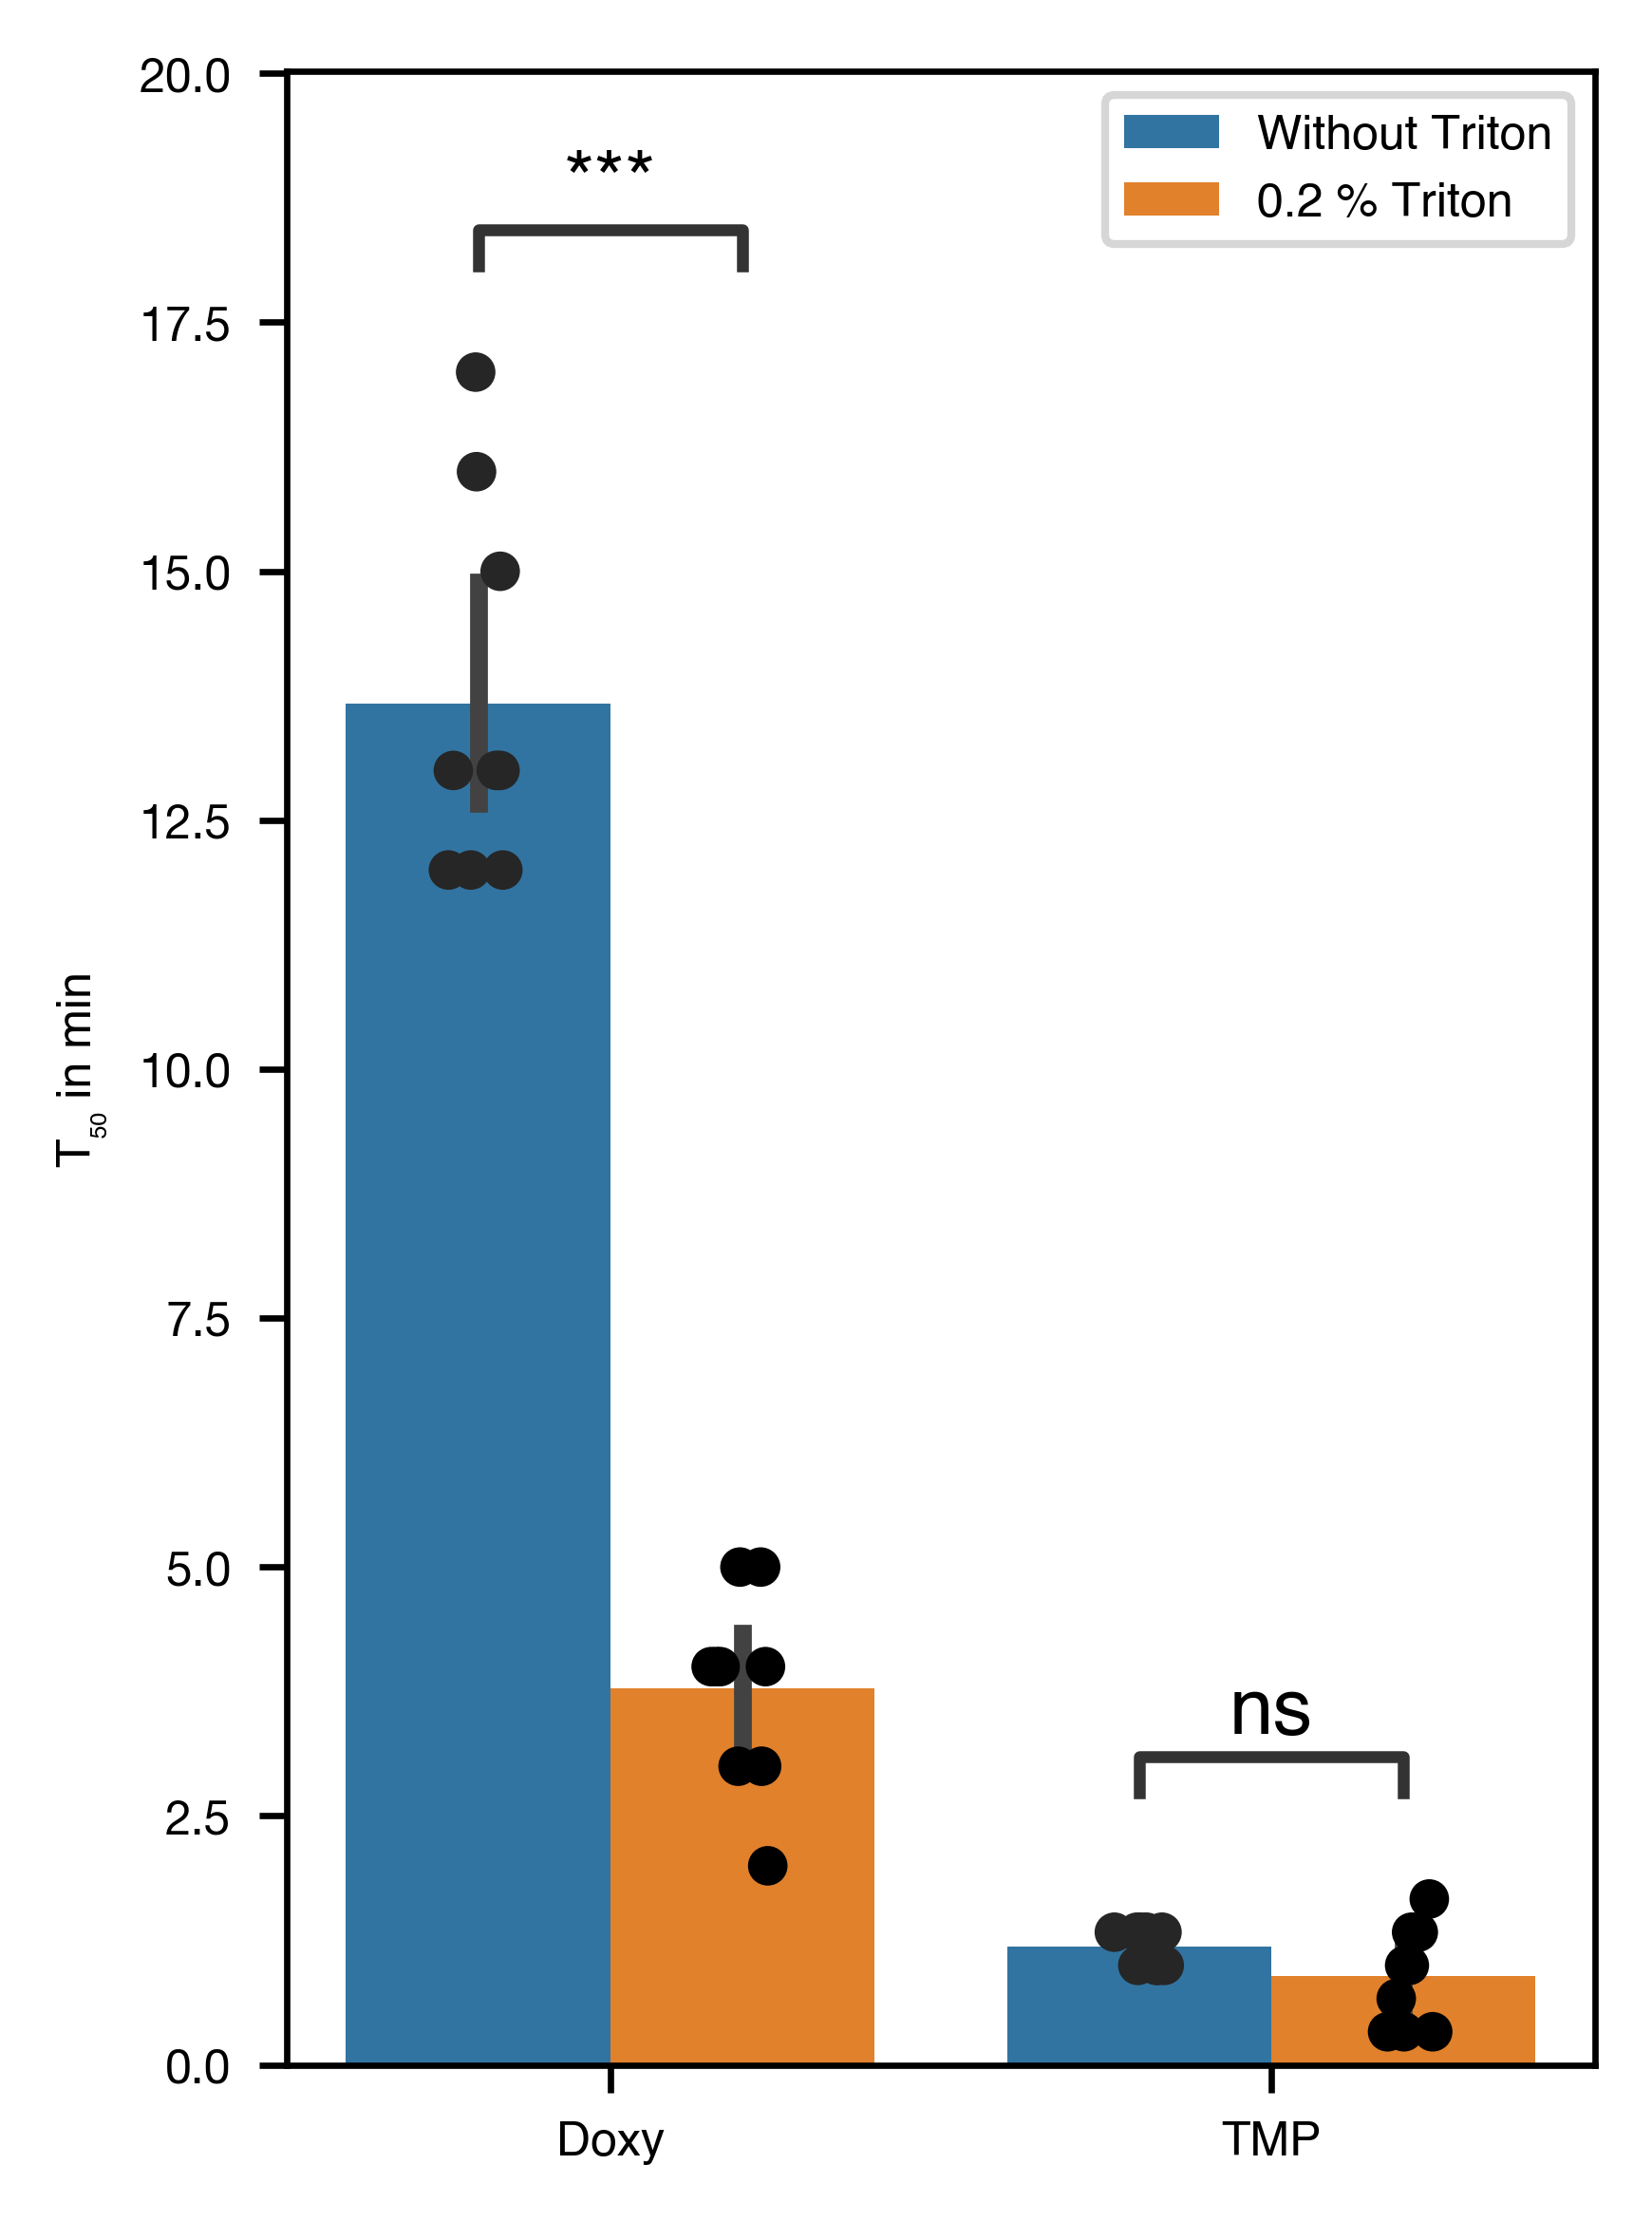

In [68]:
x = "Antibiotic"
hue = "Condition"
order = ["Tet", "Doxy", "TMP"]
order = ["Doxy", "TMP"]

plt.figure(dpi=600, figsize=[3, 4])


sns.barplot(
    times,
    x=x,
    y=time,
    hue=hue,
    order=order,
    hue_order=triton_order,
)
ax = sns.stripplot(
    times,
    x=x,
    y=time,
    hue=hue,
    dodge=True,
    palette='dark:black',
    legend=False,
    order=order,
    hue_order=triton_order,
)

pairs=[
    #(("Tet", triton[0]), ("Tet", triton[2])),
    (("Doxy", triton[0]), ("Doxy", triton[2])),
    (("TMP", triton[0]), ("TMP", triton[2])),
    
    #(("TMP", triton[0]), ("Doxy", triton[0])),
    #(("TMP", triton[2]), ("Doxy", triton[2])),
    
    #(("Tet", triton[0]), ("Doxy", triton[0])),
    #(("Tet", triton[2]), ("Doxy", triton[2])),
    
    #(("TMP", triton[0]), ("Tet", triton[0])),
    #(("TMP", triton[2]), ("Tet", triton[2])),
]

annotator = Annotator(ax, pairs, data=times, x=x, y=time, hue=hue, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

ax.set_xlabel("")
ax.legend().set_title(None)

ytick_font = font_manager.FontProperties(family="Helvetica Neue", size=ytick_fontsize)

# Anwenden auf yticks
for label in ax.get_yticklabels():
    label.set_fontproperties(ytick_font)

plt.tight_layout()
plt.savefig("/mnt/c/Users/niklas/Downloads/2025-04-22-Dasha-triton.pdf")

In [23]:
text_obj = ax.set_title("test")

In [37]:
fontname = text_obj.get_fontproperties().get_name()
fontfile = font_manager.findfont(text_obj.get_fontproperties())

fontfile

'/home/niklas/.fonts/HelveticaNeue-Regular.ttf'

KeyboardInterrupt: 

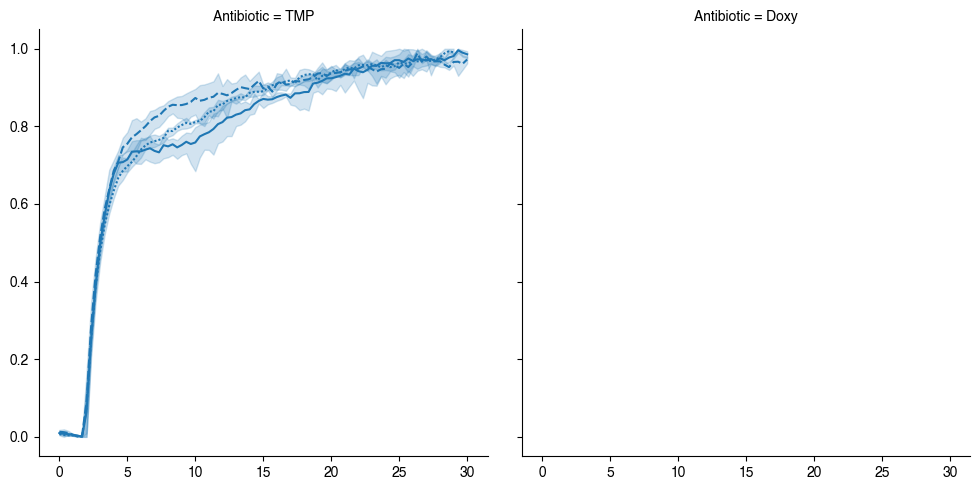

In [39]:
sns.relplot(
    df,
    x="Time, min",
    y="value",
    hue="Condition",
    style="Well",
    col="Antibiotic",
    kind="line",
)

In [ ]:
sns.relplot(
    df,
    x="Time, min",
    y="value",
    hue="Condition",
    style="Well",
    col="Antibiotic",
    kind="line",
    units="Position",
    estimator=None,
)

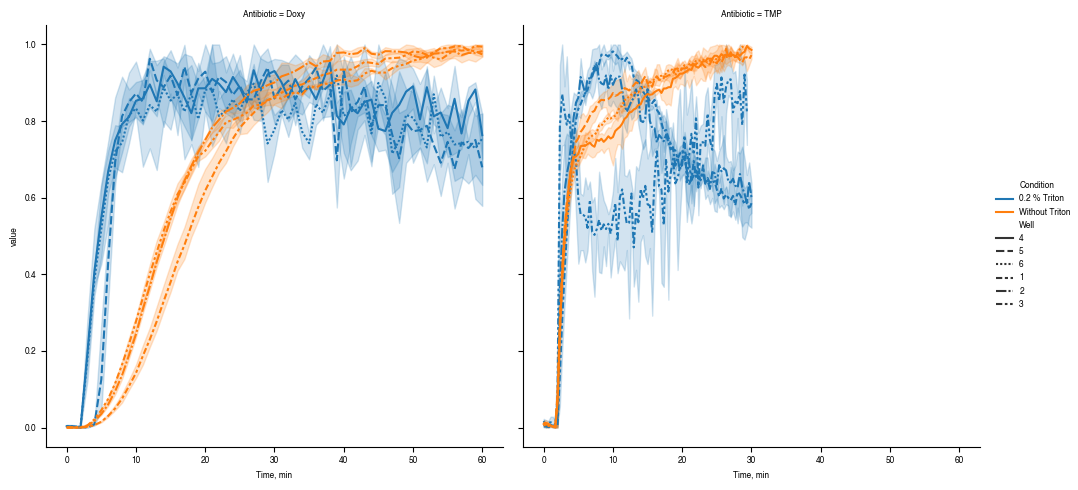

In [71]:
sns.relplot(
    means,
    x="Time, min",
    y="value",
    hue="Condition",
    style="Well",
    col="Antibiotic",
    kind="line",
)

<Figure size 3000x2400 with 0 Axes>

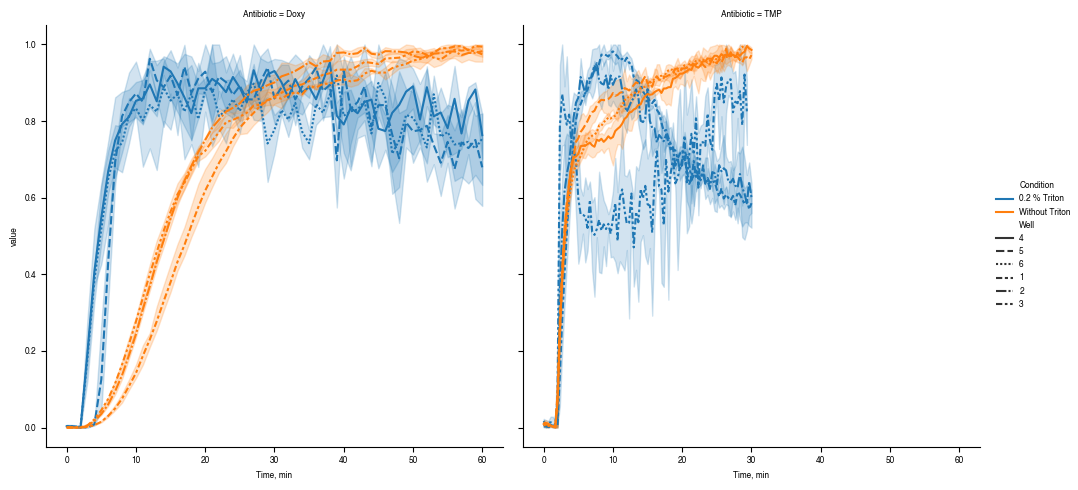

In [75]:
plt.figure(dpi=600, figsize=[5, 4])

sns.relplot(
    means,
    x="Time, min",
    y="value",
    hue="Condition",
    style="Well",
    col="Antibiotic",
    kind="line",
)

<Figure size 3000x2400 with 0 Axes>

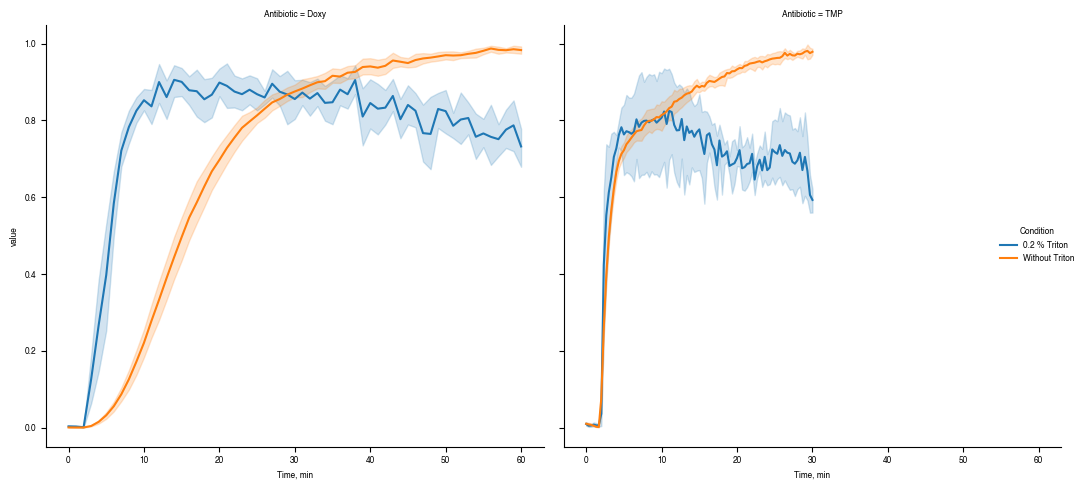

In [78]:
plt.figure(dpi=600, figsize=[5, 4])

sns.relplot(
    means,
    x="Time, min",
    y="value",
    hue="Condition",
    #style="Well",
    col="Antibiotic",
    kind="line",
)

plt.tight_layout()
plt.savefig("/mnt/c/Users/niklas/Downloads/2025-04-22-Dasha-triton-curves.pdf")

<AxesSubplot: xlabel='Time, min', ylabel='value'>

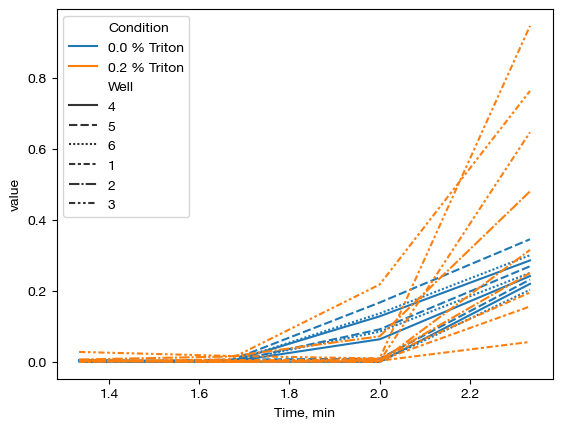

In [16]:
sns.lineplot(
    df[(df["Time, min"]>1) & (df["Time, min"]<2.5)],
    x="Time, min",
    y="value",
    hue="Condition",
    style="Well",
    units="Position",
    estimator=None,
)

In [ ]:
sns.relplot(
    df[(df["Time, min"]>1) & (df["Time, min"]<2.5)],
    x="Time, min",
    y="value",
    hue="Condition",
    style="Well",
    col="Antibiotic",
    kind="line",
    units="Position",
    estimator=None,
)

In [ ]:
sns.relplot(
    df[(df["Time, min"]<10)],
    x="Time, min",
    y="value",
    hue="Condition",
    style="Well",
    col="Antibiotic",
    kind="line",
    units="Position",
    estimator=None,
)

In [18]:
print(font_manager.findSystemFonts())

['/usr/share/fonts/truetype/lato/Lato-Italic.ttf', '/usr/share/fonts/truetype/ubuntu/UbuntuMono-B.ttf', '/usr/share/fonts/truetype/lato/Lato-Black.ttf', '/home/niklas/.fonts/Helvetica#1.ttf', '/usr/share/fonts/truetype/lato/Lato-ThinItalic.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf', '/usr/share/fonts/truetype/ubuntu/Ubuntu-RI.ttf', '/usr/share/fonts/truetype/ubuntu/Ubuntu-B.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Oblique.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSerif-BoldItalic.ttf', '/usr/share/fonts/truetype/lato/Lato-Regular.ttf', '/usr/share/fonts/truetype/ubuntu/Ubuntu-M.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSans-ExtraLight.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf', '/home/niklas/.fonts/Helvetica#4.ttf', '/usr/share/fonts/truetype/lato/Lato-Thin.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed-Bold.ttf', '/home/niklas/.fonts/Helvetica#3.ttf', '/usr/share/fonts/truetype/lato/Lato-HairlineItalic.ttf', '/usr/shar

In [23]:
for font in font_manager.fontManager.ttflist:
    print(f"{font.name} ({font.fname})")
    print(font)

STIXGeneral (/home/niklas/miniconda3/envs/vis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf)
FontEntry(fname='/home/niklas/miniconda3/envs/vis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')
DejaVu Sans (/home/niklas/miniconda3/envs/vis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf)
FontEntry(fname='/home/niklas/miniconda3/envs/vis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')
STIXSizeTwoSym (/home/niklas/miniconda3/envs/vis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf)
FontEntry(fname='/home/niklas/miniconda3/envs/vis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', v